# Notebook to Reproduce Originality Detection Findings

## Start Testground

```
$ testground daemon
```

## Run Testplans in Docker:
``` 
$ testground run single --plan=coopbc --testcase=bc --runner=local:docker --builder=docker:go --instances=10 --collect
```

### Run Testplans in K8S:
```
$ testground run single --plan=coopbc --testcase=bc --runner=cluster:k8s --builder=docker:go --instances=10 --collect --build-cfg go_proxy_mode=direct
```

# Parsing Outputs

### Find Output Dirs

In [193]:
import os

outputs_folder = "c6vhkft8gb1ak76ffd00"

docker_data_dir = "../outputs/local_docker/coopbc/"
directory_contents = os.listdir(docker_data_dir)
print(directory_contents)

['c6vqk1t8gb164co63ip0', 'c6vpm6l8gb16rl0fi2sg', 'c6vo6j58gb19og3qh6l0', 'c6vq38l8gb1eb9thm2f0', 'c6vo5kt8gb19og3qh6k0', 'c6vp5958gb11cfpkgj00', 'c6vqlf58gb164co63iqg', 'c6voprt8gb13t5nhectg', 'c6vot558gb13t5nhed10', 'c6voqpt8gb13t5nhecug', 'c6vqgod8gb164co63ilg', 'c6vqhmd8gb164co63img', 'c6vq46l8gb1eb9thm2g0', 'c6vqfqd8gb164co63ikg', 'c6voc7l8gb19og3qh6r0', 'c6vos758gb13t5nhed00', 'c6vp6758gb11cfpkgj10', 'c6vob9l8gb19og3qh6q0', 'c6vql058gb164co63iq0', 'c6vq8st8gb1eb9thm2l0', 'c6vpoht8gb16rl0fi2v0', 'c6vqi5l8gb164co63in0', 'c6vp9gd8gb11cfpkgj4g', 'c6vohl58gb19og3qh6t0', 'c6vqfbd8gb164co63ik0', 'c6vo39t8gb19og3qh6hg', 'c6vpe6l8gb11cfpkgj9g', 'c6vo7h58gb19og3qh6m0', 'c6vpcal8gb11cfpkgj7g', 'c6vo7258gb19og3qh6lg', 'c6vqg9d8gb164co63il0', 'c6vplnl8gb16rl0fi2s0', 'c6vpbcl8gb11cfpkgj6g', 'c6vq62l8gb1eb9thm2i0', 'c6vqdud8gb164co63iig', 'c6voro58gb13t5nhecvg', 'c6vp5o58gb11cfpkgj0g', 'c6vp7k58gb11cfpkgj2g', 'c6vqapl8gb1eb9thm2n0', 'c6vpput8gb16rl0fi30g', 'c6vp0tt8gb13t5nhed50', 'c6vog7t8gb19og

### Find all .out files and map them to their RUNID

In [194]:
import os
import pathlib
from pathlib import Path
import glob

def listdir_r(dirpath):
    paths=[]
    paths.append(dirpath)
    for path in os.listdir(dirpath):
        rpath = os.path.join(dirpath, path)
        if os.path.isdir(rpath):
            subdirs = listdir_r(rpath)
            if not subdirs == []:
                paths.extend(subdirs)
    return paths

all_paths_dict = {}
for d in directory_contents:
    print(docker_data_dir + d)
    all_paths = listdir_r(os.path.abspath(docker_data_dir + d))
    all_paths_containing_target = [s for s in all_paths if d in s]
    all_paths_dict[d]=all_paths_containing_target

print(all_paths_dict)

../outputs/local_docker/coopbc/c6vqk1t8gb164co63ip0
../outputs/local_docker/coopbc/c6vpm6l8gb16rl0fi2sg
../outputs/local_docker/coopbc/c6vo6j58gb19og3qh6l0
../outputs/local_docker/coopbc/c6vq38l8gb1eb9thm2f0
../outputs/local_docker/coopbc/c6vo5kt8gb19og3qh6k0
../outputs/local_docker/coopbc/c6vp5958gb11cfpkgj00
../outputs/local_docker/coopbc/c6vqlf58gb164co63iqg
../outputs/local_docker/coopbc/c6voprt8gb13t5nhectg
../outputs/local_docker/coopbc/c6vot558gb13t5nhed10
../outputs/local_docker/coopbc/c6voqpt8gb13t5nhecug
../outputs/local_docker/coopbc/c6vqgod8gb164co63ilg
../outputs/local_docker/coopbc/c6vqhmd8gb164co63img
../outputs/local_docker/coopbc/c6vq46l8gb1eb9thm2g0
../outputs/local_docker/coopbc/c6vqfqd8gb164co63ikg
../outputs/local_docker/coopbc/c6voc7l8gb19og3qh6r0
../outputs/local_docker/coopbc/c6vos758gb13t5nhed00
../outputs/local_docker/coopbc/c6vp6758gb11cfpkgj10
../outputs/local_docker/coopbc/c6vob9l8gb19og3qh6q0
../outputs/local_docker/coopbc/c6vql058gb164co63iq0
../outputs/l

### Find target JSON Outputs in .out files 

In [195]:
def check_dir_for_target_lines(search_path):
    search_str = "___UploaderData___"
    file_type = ".out"
    target_line = []
    result = []
    targets = 13 # MAGIC NUMBER for the number of outputs - i should have parsed the whole file as json and just check the exact message instead of all strings
    success = False
    for fname in os.listdir(path=search_path):
        if fname.endswith(file_type):
                fo = open(search_path + "/" + fname)
                line = fo.readline()
                line_no = 1
                while line != '' :
                        index = line.find(search_str)
                        if ( index != -1) :
                            # print(fname, "[", line_no, ",", index, "] ", line, sep="")
                            success = True
                        line = fo.readline()
                        if success == True and targets > 0:
                            result.append(line)
                            targets -= 1
                        line_no += 1
                fo.close()
    return result

output_lines_dict_by_runid = {}
for d in directory_contents:
    output = []
    output_lines = []
    paths_containing_target = all_paths_dict[d]
    for pct in paths_containing_target:
        output = check_dir_for_target_lines(pct)
        if output:
            for l in output:
                # print(l)
                output_lines.append(l)
    output_lines_dict_by_runid[d]=output_lines

print(output_lines_dict_by_runid)

{'c6vqk1t8gb164co63ip0': ['{"ts":1639950965801923317,"msg":"","group_id":"single","run_id":"c6vqk1t8gb164co63ip0","event":{"message_event":{"message":"Instances: 80"}}}\n', '{"ts":1639950965801953604,"msg":"","group_id":"single","run_id":"c6vqk1t8gb164co63ip0","event":{"message_event":{"message":"SimLatency_ms: 80"}}}\n', '{"ts":1639950965801973711,"msg":"","group_id":"single","run_id":"c6vqk1t8gb164co63ip0","event":{"message_event":{"message":"SimPeerBandwidth_bps: 1048576"}}}\n', '{"ts":1639950965801991975,"msg":"","group_id":"single","run_id":"c6vqk1t8gb164co63ip0","event":{"message_event":{"message":"SimJitter_ms: 5"}}}\n', '{"ts":1639950965802019577,"msg":"","group_id":"single","run_id":"c6vqk1t8gb164co63ip0","event":{"message_event":{"message":"SimLoss_pct: 1"}}}\n', '{"ts":1639950965802046146,"msg":"","group_id":"single","run_id":"c6vqk1t8gb164co63ip0","event":{"message_event":{"message":"SimCorrupt_pct: 1"}}}\n', '{"ts":1639950965802063679,"msg":"","group_id":"single","run_id":

### Parse Json Results to Data Frame

In [196]:
import json
import pandas as pd

#d = {'Instances': [], 'Latency': [], 'Bandwidth': [], 'Jitter': [], 'Loss': [], 'Corrupt': [], 'S2CheckDuration': [], 'OriginalityRatio': [], 'OriginalCombinations': [], 'DhtUploadDuration': [], 'DhtQueryDuration': []}


uber_data = [{}]
for runid in output_lines_dict_by_runid:
    kvs_dict = {}
    kvs_dict["RunID"] = runid
    for o in output_lines_dict_by_runid[runid]:
        m = json.loads(o)["event"]["message_event"]["message"]
        kv = m.split(": ", 1)
        if len(kv) > 1:
            kvs_dict[kv[0]] = kv[1]
    uber_data.append(kvs_dict)
uber_data.pop(0)
print(uber_data)

my_data_frame = pd.DataFrame.from_dict(uber_data)
my_data_frame

[{'RunID': 'c6vqk1t8gb164co63ip0', 'Instances': '80', 'SimLatency_ms': '80', 'SimPeerBandwidth_bps': '1048576', 'SimJitter_ms': '5', 'SimLoss_pct': '1', 'SimCorrupt_pct': '1', 'S2CheckDuration_s': '6.716052023', 'OriginalityRatio_RO': '0.7', 'UploadedOriginalCombinations': '14', 'DhtUploadDuration_s': '7.067260301', 'DhtQueryDuration_ms': '73.472667'}, {'RunID': 'c6vpm6l8gb16rl0fi2sg', 'Instances': '35', 'SimLatency_ms': '80', 'SimPeerBandwidth_bps': '1048576', 'SimJitter_ms': '5', 'SimLoss_pct': '1', 'SimCorrupt_pct': '1', 'S2CheckDuration_s': '5.797453114', 'OriginalityRatio_RO': '0.7', 'UploadedOriginalCombinations': '14', 'DhtUploadDuration_s': '6.080147197', 'DhtQueryDuration_ms': '29.031875'}, {'RunID': 'c6vo6j58gb19og3qh6l0', 'Instances': '40', 'SimLatency_ms': '80', 'SimPeerBandwidth_bps': '1048576', 'SimJitter_ms': '5', 'SimLoss_pct': '1', 'SimCorrupt_pct': '1', 'S2CheckDuration_s': '6.013415114', 'OriginalityRatio_RO': '0.7', 'UploadedOriginalCombinations': '14', 'DhtUploadDu

,RunID,Instances,SimLatency_ms,SimPeerBandwidth_bps,SimJitter_ms,SimLoss_pct,SimCorrupt_pct,S2CheckDuration_s,OriginalityRatio_RO,UploadedOriginalCombinations,DhtUploadDuration_s,DhtQueryDuration_ms
0,c6vqk1t8gb164co63ip0,80,80,1048576,5,1,1,6.716052023,0.7,14,7.067260301,73.472667
1,c6vpm6l8gb16rl0fi2sg,35,80,1048576,5,1,1,5.797453114,0.7,14,6.080147197,29.031875
2,c6vo6j58gb19og3qh6l0,40,80,1048576,5,1,1,6.013415114,0.7,14,6.359699386,22.60026
3,c6vq38l8gb1eb9thm2f0,20,80,1048576,5,1,1,5.979465262,0.7,14,6.279143126,21.738467
4,c6vo5kt8gb19og3qh6k0,30,80,1048576,5,1,1,7.531442552,0.7,14,7.81290198,17.166868
...,...,...,...,...,...,...,...,...,...,...,...,...
120,c6vq6hl8gb1eb9thm2ig,55,80,1048576,5,1,1,5.686540401,0.7,14,6.003635948,26.296833
121,c6vqj3t8gb164co63io0,70,80,1048576,5,1,1,6.168125656,0.7,14,6.810612945,39.972996
122,c6vqkgt8gb164co63ipg,85,80,1048576,5,1,1,6.269321851,0.7,14,6.877821048,50.756948
123,c6vprrd8gb16rl0fi32g,95,80,1048576,5,1,1,4.993059658,0.7,14,5.317404278,37.52767


### S2 Check Duration

<AxesSubplot:xlabel='Instances'>

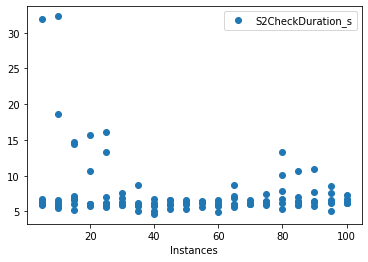

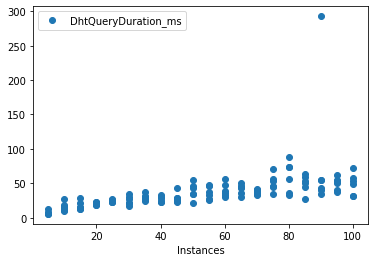

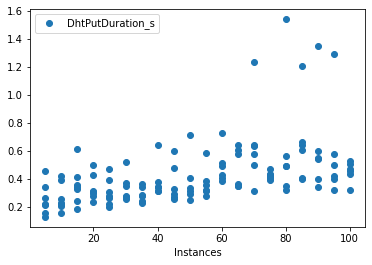

In [223]:
import matplotlib.pyplot as plt
import numpy as np

my_data_frame.Instances=pd.to_numeric(my_data_frame.Instances)
my_data_frame.S2CheckDuration_s=pd.to_numeric(my_data_frame.S2CheckDuration_s)
my_data_frame.DhtUploadDuration_s=pd.to_numeric(my_data_frame.DhtUploadDuration_s)
my_data_frame.DhtQueryDuration_ms=pd.to_numeric(my_data_frame.DhtQueryDuration_ms)
my_data_frame['DhtPutDuration_s'] = my_data_frame['DhtUploadDuration_s'] - my_data_frame['S2CheckDuration_s']
my_data_frame.plot(x='Instances', y='S2CheckDuration_s', style='o')
# my_data_frame.plot(x='Instances', y='DhtUploadDuration_s', style='o')
my_data_frame.plot(x='Instances', y='DhtQueryDuration_ms', style='o')
my_data_frame.plot(x='Instances', y='DhtPutDuration_s', style='o')


### Figures from DataFrame

### Seaborn Plots

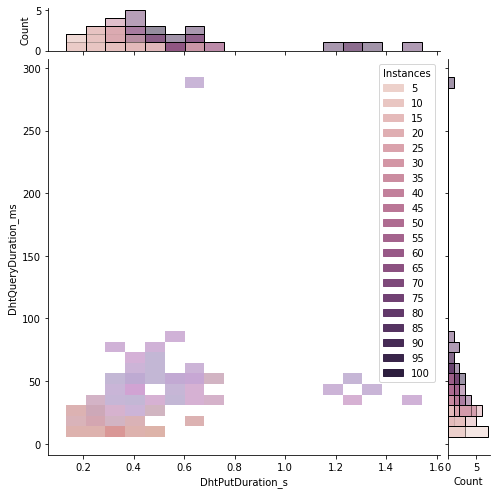

In [226]:
sns.jointplot(data=my_data_frame, x="DhtPutDuration_s", y="DhtQueryDuration_ms", hue="Instances", kind="hist", height=7, ratio=8, marginal_ticks=True)